# __Reference:__

* [TensorFlow for Computer Vision — How to Implement Convolutions From Scratch in Python](https://betterdatascience.com/implement-convolutions-from-scratch-in-python/)
* [Enhancements to Numba's guvectorize decorator](https://labs.quansight.org/blog/2021/02/enhancements-to-numba-guvectorize-decorator/)
* [Stencil Computations with Numba¶](https://examples.dask.org/applications/stencils-with-numba.html)
* [Composing Dask Array with Numba Stencils](https://blog.dask.org/2019/04/09/numba-stencil)

In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from numba import guvectorize, int16, int8, float32, prange

def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    
def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')

sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

outline = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

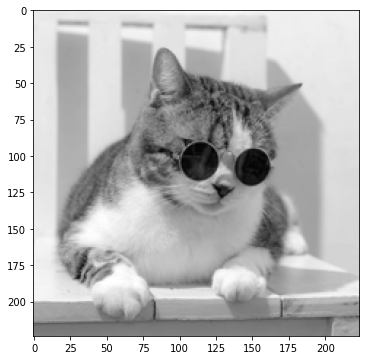

In [2]:
img = Image.open('cat.jpg')
img = ImageOps.grayscale(img)
img = img.resize(size=(224, 224))
plot_image(img=img)

In [3]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
    return num_pixels


def convolve_np(img: np.array, kernel: np.array) -> np.array:
    # Assuming a rectangular image
    tgt_size = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=kernel.shape[0]
    )

    # To simplify things
    k = kernel.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    
    # Iterate over the rows
    for i in range(tgt_size):
        # Iterate over the columns
        for j in range(tgt_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i:i+k, j:j+k]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
    return convolved_img

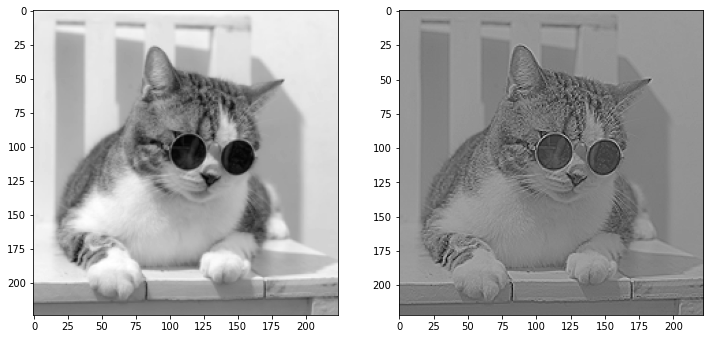

In [4]:
img_sharpened_np = convolve_np(img=np.array(img), kernel=sharpen)
plot_two_images(
    img1=img, 
    img2=img_sharpened_np
)

In [5]:
@guvectorize([(int16[:,:], int8[:,:], float32, float32, int16[:,:])],'(n,n),(m,m),(),()->(n,n)', nopython = True, fastmath = True,  target_backend='cpu')
def convolve_nb(img, kernel, tgt_size, kernel_size, convolved_img):
    for i in prange(tgt_size):
        for j in prange(tgt_size):
            mat = img[i:i+kernel_size, j:j+kernel_size]
            res = 0
            for k in prange(kernel_size):
                for l in prange(kernel_size):
                    res = res + (mat[k, l] * kernel[k, l])
            convolved_img[i, j] = res

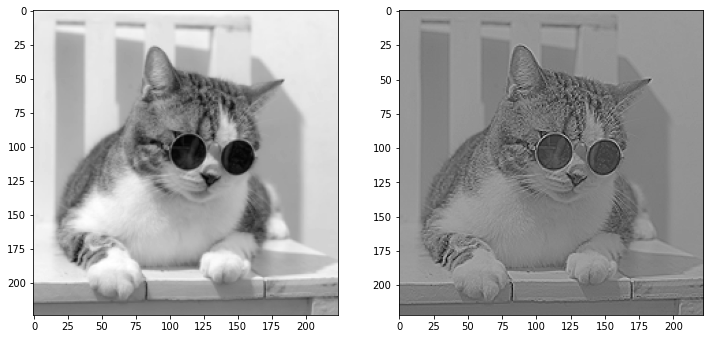

In [6]:
image_mat = np.array(img).astype(np.int16)
sharpen = sharpen.astype(np.int8)
img_size = image_mat.shape[0]
kernel_size = sharpen.shape[0]
tgt_size = calculate_target_size(img_size, kernel_size)
convolved_img = np.zeros_like(image_mat)
convolve_nb(image_mat, sharpen, tgt_size, kernel_size, convolved_img)
img_sharpened_nb = convolved_img[0:tgt_size,0:tgt_size]
plot_two_images(
    img1=img, 
    img2=img_sharpened_nb
)

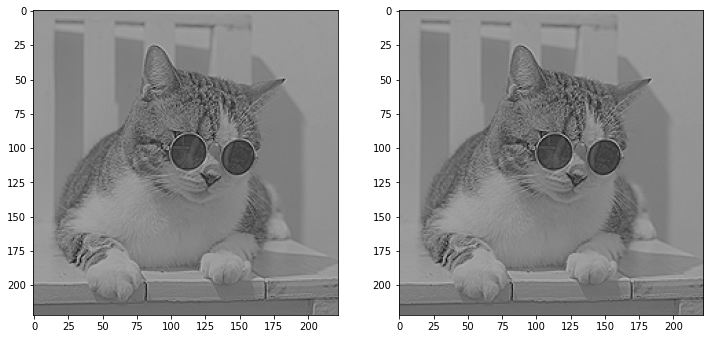

In [7]:
plot_two_images(
    img1=img_sharpened_np, 
    img2=img_sharpened_nb
)

In [8]:
%timeit img_sharpened = convolve_np(img=np.array(img), kernel=sharpen)
%timeit convolve_nb(image_mat, sharpen, tgt_size, kernel_size, convolved_img)

295 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.11 ms ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
